In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploration of dataset 

In [247]:
df = pd.read_csv('data/survey_results_public.csv', low_memory=False)
print(f'Shape Dataset:\t{df.shape}')

Shape Dataset:	(98855, 129)


This dataset has around 100k respondents with 129 questions. We will filter for questions which we consider to be potentially relevant for Section 2. Since data manipulation will be long and ardous if we consider all ~130 column headings). I chosen to ignored almost from Q19 (AssessJob1) until the end of the questionnaire apart from ConvertedSalary, Gender, and Age. I made the assumption that these Likert Scale type questions will not add much predictive power to classify the number of years coding experience a respondee has.  

In [248]:
# Filter columns for relevant data
df = df[['Country',
         'Employment',
         'CompanySize',
         'DevType',
         'YearsCoding',
         'YearsCodingProf',
         'ConvertedSalary',
         'Gender',
         'Dependents',
         'Student',
         'FormalEducation',
         'UndergradMajor',
         'Age']]

First, we look at the breakdown of the types of jobs surveyed to see if we can learn anything interesting.  

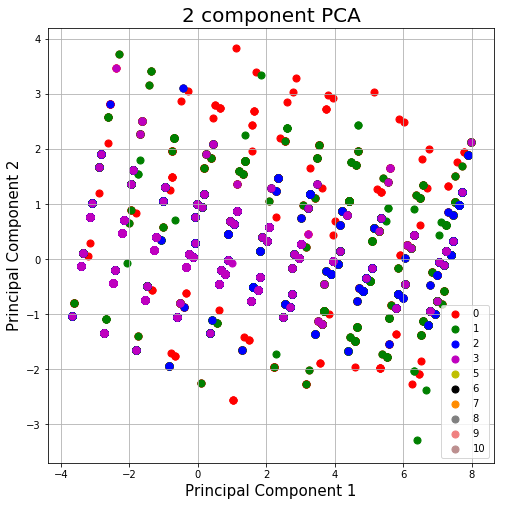

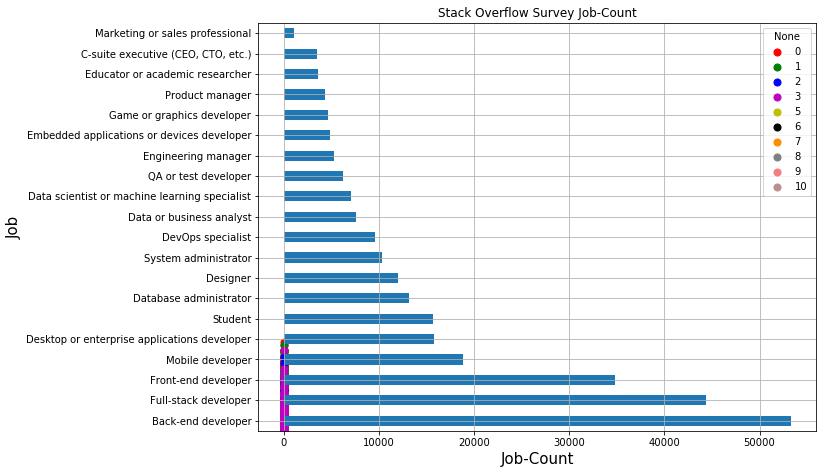

In [249]:
# Split the jobs and count them
df_jobs = pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True).value_counts()

# Create plot
df_jobs.plot(kind='barh', figsize=(10,7.5))
plt.title('Stack Overflow Survey Job-Count')
plt.xlabel('Job-Count')
plt.ylabel('Job')
plt.grid()
plt.show()

I make the hypothesis that developers, machine learning specialist, or DevOps will have a YearsCoding distribution skewed to higher numbers. I make this assumption since these are roles which tend to require hands-on software developement whereas management type roles usually do not.   

In [250]:
# Make two dataframes one for developers and one for management

# Drop empty values
df = df.dropna(subset=['DevType'])

# Create dfs
df_dev = df[df['DevType'].str.contains('developer|DevOps|machine learning|Database|Engineering|researcher')] 
df = df[~df.isin(df_dev)].dropna()

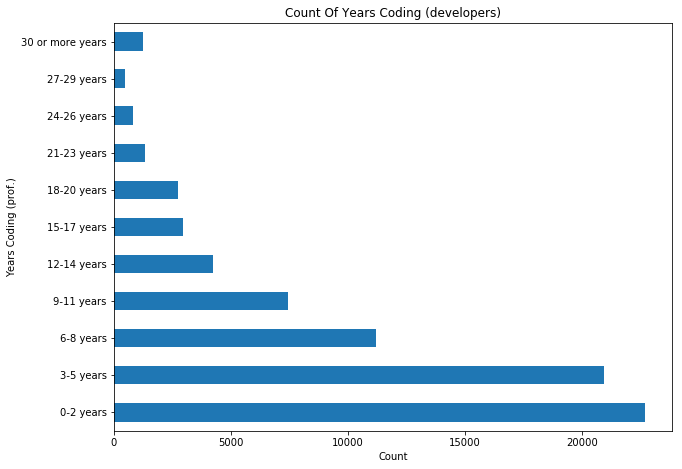

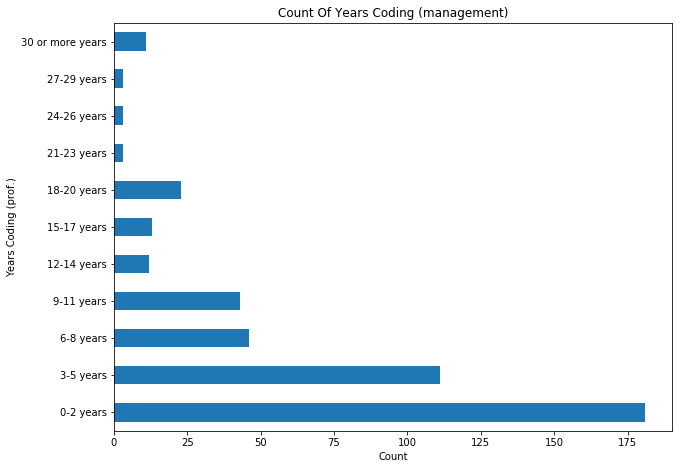

In [251]:
"""Transform years coding from a categorical 
string into an ordered numberical feature since 
we will train on this we want to preserve the order"""
years_coding = ['0-2 years', '3-5 years', '6-8 years', '9-11 years', '12-14 years', '15-17 years', '18-20 years', '21-23 years', '24-26 years', '27-29 years', '30 or more years']

# Create plots
df_dev['YearsCodingProf'].value_counts().reindex(years_coding).plot(kind='barh', figsize=(10,7.5))
plt.title('Count Of Years Coding (developers)')

plt.xlabel('Count')
plt.ylabel('Years Coding (prof.)')
plt.show()

df['YearsCodingProf'].value_counts().reindex(years_coding).plot(kind='barh', figsize=(10,7.5))
plt.title('Count Of Years Coding (management)')
plt.xlabel('Count')
plt.ylabel('Years Coding (prof.)')
plt.show()

This hypothesis seems to hold true in that the distribution of the lowermost plot is skewed more to less years coding experience. I create a new binary variable for DevType: 0 for management, 1 for developers.

NB. I choose YearsCodingProf as the target variable

In [252]:
# Add new binary variable for management and developer instead of DevType
df = df.drop('DevType', axis=1)
df['DevType'] = 0
df_dev = df_dev.drop('DevType', axis=1)
df_dev['DevType'] = 1

df2 = pd.concat([df, df_dev], axis=0)
print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(87295, 13)


Now let's check salaries to see if we can see anything interesting

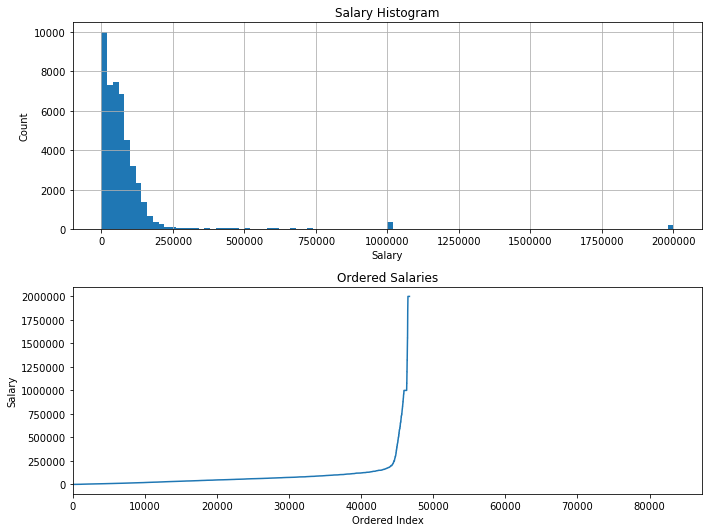

In [253]:
# Create subplots
fig, axarr = plt.subplots(2, figsize=(10,7.5))

# Create histogram
df2['ConvertedSalary'].hist(bins=100, ax=axarr[0])
axarr[0].set_title('Salary Histogram')
axarr[0].set_xlabel('Salary')
axarr[0].set_ylabel('Count')

# Create sorted plot
df2['ConvertedSalary'].sort_values().reset_index(drop=True).plot(ax=axarr[1])
axarr[1].set_title('Ordered Salaries')
axarr[1].set_xlabel('Ordered Index')
axarr[1].set_ylabel('Salary')


plt.tight_layout()
plt.show()

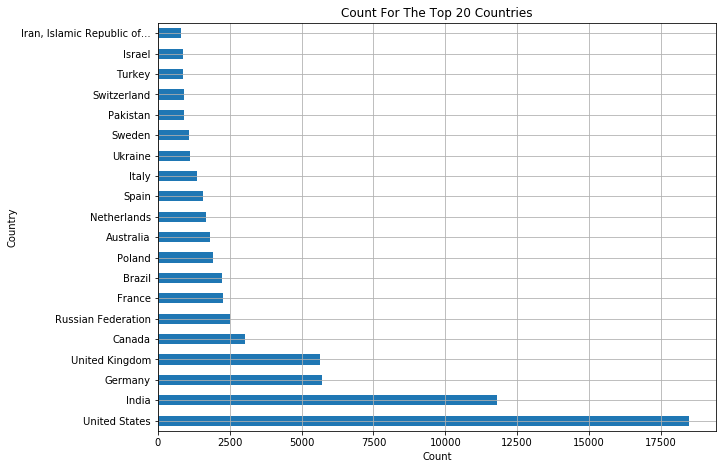

In [254]:
"""Check the breakdown of the home 
country of the respondents. Limit to the top 20"""
n = 20

# Create plot
df_country = df2['Country'].value_counts().head(n)
df_country.plot(kind='barh', figsize=(10,7.5))
plt.title('Count For The Top {} Countries'.format(n))
plt.xlabel('Count')
plt.ylabel('Country')
plt.grid()
plt.show()

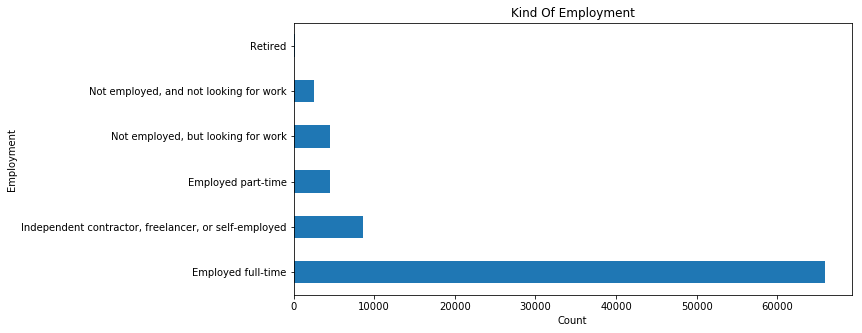

Shape Dataset:	(87295, 13)


In [255]:
# Look at employment type
df2['Employment'].value_counts().plot(kind='barh', figsize=(10,5))
plt.title('Kind Of Employment')
plt.xlabel('Count')
plt.ylabel('Employment')
plt.show()

print(f'Shape Dataset:\t{df2.shape}')

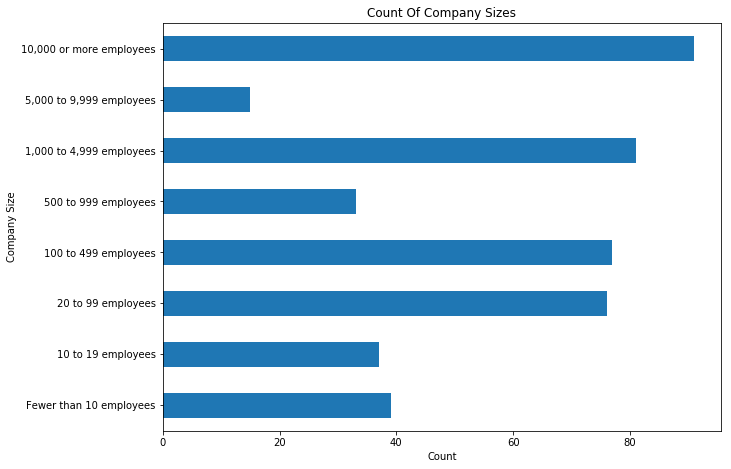

In [256]:
# Ordered company size
company_size = ['Fewer than 10 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', '500 to 999 employees', '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees']

# Create plot
df['CompanySize'].value_counts().reindex(company_size).plot(kind='barh', figsize=(10,7.5))
plt.title('Count Of Company Sizes')
plt.xlabel('Count')
plt.ylabel('Company Size')
plt.show()

There are less than a few hundred filled values for this variable so I will not consider it for the classifier.

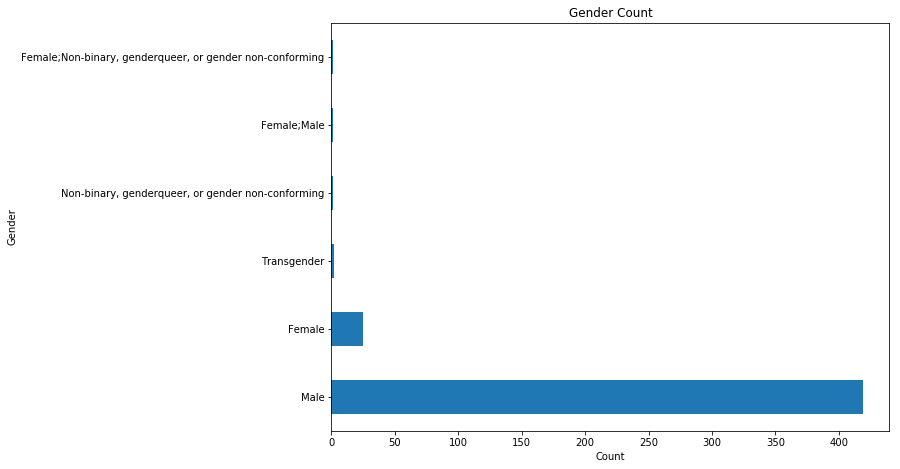

In [257]:
# Create plot
df['Gender'].value_counts().plot(kind='barh', figsize=(10,7.5))
plt.title('Gender Count')
plt.xlabel('Count')
plt.ylabel('Gender')
plt.show()

The breakdown of respondees is predominantly male from the US which is expected. I will not consider the gender, country of origin, or number of employees as input features since I do not expect them to have a causal relationship to the YearsCodingProf

In [258]:
# Create mapping for years coding
mapping_years_coding = {key:i for i, key in enumerate(years_coding)}

# Drop empty values
df2 = df2.dropna(subset=['YearsCoding'])
df2 = df2.dropna(subset=['YearsCodingProf'])

# Transform category to numerical column
df2['YearsCoding'] = df2['YearsCoding'].map(mapping_years_coding)
df2['YearsCodingProf'] = df2['YearsCodingProf'].map(mapping_years_coding)

print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(76545, 13)


In [259]:
# Create mapping for years coding
df2['Dependents'] = df2['Dependents'].map({'No':0, 'Yes':1})
df2 = df2.dropna(subset=['Dependents'])

print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(58031, 13)


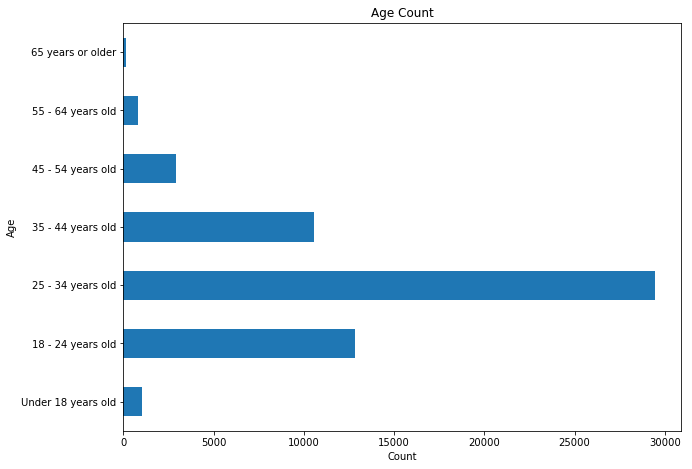

Shape Dataset:	(57758, 13)


In [260]:
# Ordered age sacle
age = ['Under 18 years old',
       '18 - 24 years old',
       '25 - 34 years old',
       '35 - 44 years old',
       '45 - 54 years old',
       '55 - 64 years old',
       '65 years or older']

# Empty values
df2 = df2.dropna(subset=['Age'])

# Create plot
df2['Age'].value_counts().reindex(age).plot(kind='barh', figsize=(10,7.5))
plt.title('Age Count')
plt.xlabel('Count')
plt.ylabel('Age')
plt.show()

print(f'Shape Dataset:\t{df2.shape}')

In [261]:
# Create mapping for years coding
mapping_age = {key:i for i, key in enumerate(age)}

# Transform category to numerical column
df2['Age'] = df2['Age'].map(mapping_age)

print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(57758, 13)


In [262]:
"""
Check correlations now to see which variables already considered are potentially useful. 
Differences of correlation between signal and background are also useful. 
"""

df2.corr()

,YearsCoding,YearsCodingProf,ConvertedSalary,Dependents,Age,DevType
YearsCoding,1.000000,0.869522,0.130877,0.335914,0.717078,0.007635
YearsCodingProf,0.869522,1.000000,0.144409,0.382482,0.772750,0.013537
ConvertedSalary,0.130877,0.144409,1.000000,0.052116,0.135853,-0.008992
Dependents,0.335914,0.382482,0.052116,1.000000,0.391264,-0.009494
Age,0.717078,0.772750,0.135853,0.391264,1.000000,-0.016484
DevType,0.007635,0.013537,-0.008992,-0.009494,-0.016484,1.000000


The variables which are correlated highly to our target variable for Section 2 (YearsCodingProf) are Age, and YearsCoding. This is expected since the older you are the more likely you are to have been a developer for longer. The amount of time a developer has been coding in their lifetime is expected to correlate highly to the amount of they have coded professionally. 

The rest of the variables in the table are not correlated at all, including DevType which looked useful earlier. I have also added the number of dependents since that could correlate slightly to age, which may help the classifier. 

In [263]:
df2 = df2[['YearsCoding',
           'YearsCodingProf',
           'Dependents',
           'Age']]

bins = [-1, 2, 6, 9,10]
labels =[0,1,2,3]
df2['YearsCodingProf'] = pd.cut(df2['YearsCodingProf'], bins,labels=labels)

# Make a 90% / 10% train-test split.
train = df2.sample(frac=0.80, random_state=0)
test = df2.drop(train.index)

# Balance test set so our class sizes are equal
test_b = test.groupby('YearsCodingProf')
test_b = pd.DataFrame(test_b.apply(lambda x: x.sample(test_b.size().min()).reset_index(drop=True)))

train.to_csv("/Users/michaelsigamani/train.csv",index=False)
test_b.to_csv("/Users/michaelsigamani/test.csv",index=False)

In [264]:
print(f'Shape (train):\t{train.shape}')
print(f'Shape (test):\t{test.shape}')

Shape (train):	(46206, 4)
Shape (test):	(11552, 4)


In [265]:
test_b['YearsCodingProf'].value_counts().sort_index()

0    185
1    185
2    185
3    185
Name: YearsCodingProf, dtype: int64

# Principle Components Analysis for segmentation

The idea here is to use the previously defined features, with the target in order to reduce the dimensionality using the first two principle components. If we see some clusters emerging we can attempt to learn something about any clear segmentations in the data. We could use a k-means clusting if so.

In [239]:
# Use sci-kit learn for their PCA module
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df2)
pca.explained_variance_ratio_

array([0.91161086, 0.05107242])

90% of the variance of the data can be explained from the first principle component, and 6% with the 2nd. 

In [243]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df2[['YearsCodingProf']]], axis = 1)

finalDf = finalDf.dropna(subset=['principal component 1'])
finalDf = finalDf.dropna(subset=['principal component 2'])
finalDf = finalDf.dropna(subset=['YearsCodingProf'])

finalDf.drop_duplicates()
print(f'Shape train:\t{finalDf.shape}')

Shape train:	(37603, 3)


In [244]:
finalDf.sample(3)

,principal component 1,principal component 2,YearsCodingProf
39314,-3.420364,-0.127916,1
5169,-1.274442,0.164665,1
33702,0.128732,0.946229,0


In [245]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
colors = ['r', 'g', 'b', 'm', 'y', 'k', 'darkorange', 'gray', 'lightcoral', 'rosybrown', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['YearsCodingProf'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

No real clusters can be seen given the data. 

Notes about training. Decided to rebin to four bins was not accurate enough (50% on test set). 

1) Used tensorflow and a DNN since this afforded the flexability to 
84% imbalanced
60% balanced 